## Case Study - Majority vote

The goal of this notebook is to explore the performance of GPT-3 in majority vote questions on our 20 question dataset.  Specifically, we want to give a question, five answers, and let GPT-3 aggregate them into one single answer.

1. Imports and functions
2. Simple approach
3. Chain of thought

We have run this notebook already with text-davinci-002 and text-davinci-003.  Now we run with chatGPT and compare results and see if our conclusion changes.

## 1. Imports and functions

In [3]:
import re
import os
import openai
from time import time, sleep
import textwrap
import pandas as pd

In [2]:
def open_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as infile:
        return infile.read()


def save_file(filepath, content):
    with open(filepath, 'w', encoding='utf-8') as outfile:
        outfile.write(content)

# change path to where you store your credentials
openai.api_key = open_file('../../creds/creds.txt')

openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who won the world series in 2020?"},
        {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
        {"role": "user", "content": "Where was it played?"}
    ]
)

def gpt3_completion(system_prompt, user_prompt, label='gpt4', engine='gpt-4'):
    max_retry = 5
    retry = 0
    user_prompt = user_prompt.encode(encoding='ASCII', errors='ignore').decode()  # force it to fix any unicode errors
    system_prompt = system_prompt.encode(encoding='ASCII', errors='ignore').decode()  # force it to fix any unicode errors
    while True:
        try:
            response = openai.ChatCompletion.create(
                      model=engine,
                      messages=[
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": user_prompt}
                        ]
                    )
            text = response['choices'][0]['message']['content'].strip()
            text = re.sub('\s+', ' ', text)
            return text
        except Exception as oops:
            retry += 1
            if retry >= max_retry:
                return "GPT3 error: %s" % oops
            print('Error communicating with OpenAI:', oops)
            sleep(1)


In [4]:
df_maj = pd.read_csv('majority_questions.csv')

In [5]:
df_maj

,question_number,question,answer_1,answer_2,answer_3,answer_4,answer_5,validation
0,1,What is left in the box?,"The box has a pencil, another 10 pencils and a...",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and anothe...",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and anot...",The box has 11 pencils and a strawberry.
1,2,What is left in the box?,"The box has a pencil, another 10 pencils and a...",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and anothe...",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and anot...",The box has 21 pencils and a strawberry.
2,3,Should congress pass the law?,The law should go through,The law should be banned,The law should get the greenlight,The law should not be part of the constitution,The law should be implemented,The law should go through
3,4,Should congress pass the law?,The law should go through,The law should be banned,The law should get the greenlight,The law should not be part of the constitution,The law should not be implemented,The law should not be implemented
4,5,Did the experiment work correctly?,Yes,No,I don't know,Most likely,Probably,Yes
5,6,Did the experiment work correctly?,Yes,No,I don't know,I'm not sure,Probably not,No
6,7,How should I wash my hands?,Use handsoap,Use soap,Use alcohol,Use aloe vera soap,Use shampoo,Soap
7,8,How should I wash my hands?,Use hair shampoo,Use soap,Use shampoo,Use aloe vera soap,Use shampoo,Shampoo
8,9,What should we eat today?,Pizza,Sushi,Pizza or Sushi,Sushi,Hamburger,Sushi
9,10,What should we eat today?,Pizza,Sushi,Pizza,Sushi or Pizza,Hamburger,Pizza


## 2. Simple approach

We'll use the following template:

In the text below we have 5 answers to the same question.

ANSWERS:

- answer_1
- answer_2
- answer_3
- answer_4
- answer_5

What is the answer to "__question__". Count how many times each answer appears, and choose the most frequent.

Also, we will use the function for finding if two answers are equivalent, as we explored in the prior notebook "Case Study - Validation"

In [6]:
## Validation function
def equiv(question, answer_1, answer_2):
    prompt_beginning = """In the following text we have a question and two answers.  Are the two answers the same? Answer with "Yes" or "No" """            
    nl_str = """\n\n"""
    question_str = """QUESTION:\n"""
    answers_str = """ANSWERS: \n"""
    final_answer_cot = """Are they the same answer? Use step by step reasoning and then output only a "Yes" or "No" answer:"""
    user_prompt = prompt_beginning + nl_str + question_str + question + nl_str + answers_str + "-" + answer_1 + "\n" + "-" + answer_2 + nl_str + final_answer_cot
    system_prompt = "You are a smart expert AI system capable of helping with language tasks."
    final_answer = gpt3_completion(system_prompt, user_prompt)
    if final_answer not in ['Yes','No']:
        prompt_init = """Condense the following sentence into a simple "Yes" or "No" answer"""
        prompt = prompt_init + nl_str + final_answer + nl_str + """ "Yes" or "No" output: """
        final_a = gpt3_completion(system_prompt, user_prompt)
        final_a.replace('.','').replace(' ','')
        final_answer = final_a
    final_answer.replace('.','').replace(' ','')
    return final_answer
    

In [6]:
#temp_list = [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1]

In [7]:
prompt_beginning = """In the text below we have 5 answers to the same question."""            
nl_str = """\n\n"""
answers_str = """ANSWERS: \n"""
final_str_1 = """What is the answer to \""""
final_str_2 = """\". Count how many times each answer appears, and choose the most frequent.  Only output your final answer string, not a sentence."""


In [10]:
score_list = []
gpt_cot_list = []
gpt_val_list = []
system_prompt = "You are a smart expert AI system capable of helping with language tasks."
for row in df_maj.iterrows():
    question = row[1]['question']
    answers_concat =  "\n -" + row[1]['answer_1'] + "\n -" + row[1]['answer_2'] + "\n -" + row[1]['answer_3'] + "\n -" + row[1]['answer_4'] + "\n -" + row[1]['answer_5']
    user_prompt = prompt_beginning + nl_str + answers_str + answers_concat + nl_str + final_str_1 + question + final_str_2
    print(user_prompt)
    final_answer = gpt3_completion(system_prompt, user_prompt)
    #print(final_answer)
    #final_answer.replace('.','').replace(' ','')
    print(row[0])
    gpt_cot_list.append(final_answer)
    equiv_string = equiv(question, final_answer, row[1]['validation'])
    if equiv_string not in ['Yes','No']:
        prompt_init = """Condense the following sentence into a simple "Yes" or "No" answer"""
        user_prompt = prompt_init + nl_str + final_answer + nl_str + """ "Yes" or "No" output: """
        final_a = gpt3_completion(system_prompt, user_prompt)
        final_a.replace('.','').replace(' ','')
        equiv_string = final_a
    gpt_val_list.append(equiv_string)
col_string_cot = 'CoT_chat'
col_string_val = 'Val_chat'
df_maj[col_string_cot] = gpt_cot_list
df_maj[col_string_val] = gpt_val_list
# validate against real answers using the equiv function above 
score = sum(df_maj[col_string_val]=='Yes')/20
score_list.append(score) 

In the text below we have 5 answers to the same question.

ANSWERS: 

 -The box has a pencil, another 10 pencils and a strawberry.
 -The box has 21 pencils and a strawberry.
 -The box has a pencil, a strawberry, and another 10 pencils.
 -The box has 21 pencils and a strawberry.
 -The box has 10 pencils, a strawberry, and another pencil.

What is the answer to "What is left in the box?". Count how many times each answer appears, and choose the most frequent.  Only output your final answer string, not a sentence.
0
In the text below we have 5 answers to the same question.

ANSWERS: 

 -The box has a pencil, another 10 pencils and a strawberry.
 -The box has 21 pencils and a strawberry.
 -The box has a pencil, a strawberry, and another 10 pencils.
 -The box has 21 pencils and a strawberry.
 -The box has 10 pencils, a strawberry, and another 11 pencils.

What is the answer to "What is left in the box?". Count how many times each answer appears, and choose the most frequent.  Only output yo

In [31]:
df_maj['CoT_chat'][19]
# 0 is wrong
# 1 is correct
# 2 is correct
# 3 is wrong
# 4 is wrong, but has a point (it points to uncertainty maybe)
# 5 is wrong, but has a point (it points to uncertainty maybe)
# 6 is correct
# 7 is correct
# 8 is wrong
# 9 is correct (probably just luck, but correct)
# 10 is correct
# 11 is wrong
# 12 is correct, kind of
# 13 is correct, chatGPT had this one wrong
# 14 is correct
# 15 is correct
# 16 is correct
# 17 is correct
# 18 is wrong, but trick question
# 19 is correct

'The answer to "Who is going to the movies?" is "Sophie" (appeared twice, the most frequent).'

So if we are being benign, we would say 13 out of 17 answers were correct, giving a 76% accuracy which is still not great (we would like to see it above 90-95%).  chatGPT had one more wrong answer than this (the rest were the same answers pretty much), which put it at 70% accuracy.

In [32]:
df_maj #['CoT_chat']


,question_number,question,answer_1,answer_2,answer_3,answer_4,answer_5,validation,CoT_chat,Val_chat
0,1,What is left in the box?,"The box has a pencil, another 10 pencils and a...",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and anothe...",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and anot...",The box has 11 pencils and a strawberry.,"The most frequent answer to ""What is left in t...",Yes.
1,2,What is left in the box?,"The box has a pencil, another 10 pencils and a...",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and anothe...",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and anot...",The box has 21 pencils and a strawberry.,"The most frequent answer is ""The box has 21 pe...",Yes.
2,3,Should congress pass the law?,The law should go through,The law should be banned,The law should get the greenlight,The law should not be part of the constitution,The law should be implemented,The law should go through,"The most frequent answer is ""The law should go...",Yes.
3,4,Should congress pass the law?,The law should go through,The law should be banned,The law should get the greenlight,The law should not be part of the constitution,The law should not be implemented,The law should not be implemented,"The answer is ""The law should go through"" as i...",Yes.
4,5,Did the experiment work correctly?,Yes,No,I don't know,Most likely,Probably,Yes,"The most frequent answer is ""I don't know"".",No.
5,6,Did the experiment work correctly?,Yes,No,I don't know,I'm not sure,Probably not,No,"The most frequent answer is ""I don't know"".",No.
6,7,How should I wash my hands?,Use handsoap,Use soap,Use alcohol,Use aloe vera soap,Use shampoo,Soap,"The most frequent answer to ""How should I wash...",Yes.
7,8,How should I wash my hands?,Use hair shampoo,Use soap,Use shampoo,Use aloe vera soap,Use shampoo,Shampoo,"The most frequent answer is ""Use shampoo"" whic...",Yes.
8,9,What should we eat today?,Pizza,Sushi,Pizza or Sushi,Sushi,Hamburger,Sushi,"Based on the provided answers, the most freque...",No.
9,10,What should we eat today?,Pizza,Sushi,Pizza,Sushi or Pizza,Hamburger,Pizza,"Based on the given answers, the most frequent ...",Yes.


#### Old results:

In [9]:
df_results = pd.DataFrame(list(zip(temp_list, score_list)), columns =['Temp', 'Score'])
df_results

,Temp,Score
0,0.20,0.45
1,0.40,0.45
2,0.60,0.50
3,0.80,0.40
4,0.90,0.50
5,0.95,0.50
6,1.00,0.45


Not a success, and not much of a difference with the prior model as seen below.


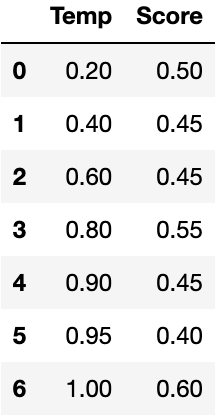

In [12]:
from IPython.display import Image
Image("img/majority_1.png", width= 110)

In [10]:
df_maj

,question_number,question,answer_1,answer_2,answer_3,answer_4,answer_5,validation,CoT_0.2,Val_0.2,...,CoT_0.6,Val_0.6,CoT_0.8,Val_0.8,CoT_0.9,Val_0.9,CoT_0.95,Val_0.95,CoT_1,Val_1
0,1,What is left in the box?,"The box has a pencil, another 10 pencils and a...",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and anothe...",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and anot...",The box has 11 pencils and a strawberry.,"Answer: The box has a pencil, another 10 penci...",No,...,"Answer: The box has a pencil, another 10 penci...",Yes,"Answer: The box has a pencil, another 10 penci...",No,"The answer is: The box has a pencil, another 1...",Yes,"Answer: The box has a pencil, another 10 penci...",No,"Answer: The box has a pencil, another 10 penci...",No
1,2,What is left in the box?,"The box has a pencil, another 10 pencils and a...",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and anothe...",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and anot...",The box has 21 pencils and a strawberry.,Answer: The box has 21 pencils and a strawberry.,Yes,...,Answer: The box has 21 pencils and a strawberry.,Yes,Answer: The box has 21 pencils and a strawberry.,Yes,"Answer: The box has a pencil, 10 pencils and a...",No,Answer: The box has 21 pencils and a strawberry.,Yes,Answer: The box has 21 pencils and a strawberry.,Yes
2,3,Should congress pass the law?,The law should go through,The law should be banned,The law should get the greenlight,The law should not be part of the constitution,The law should be implemented,The law should go through,The law should go through.,Yes,...,The law should go through.,Yes,The law should go through.,Yes,The law should go through.,Yes,The law should go through.,Yes,The law should go through.,Yes
3,4,Should congress pass the law?,The law should go through,The law should be banned,The law should get the greenlight,The law should not be part of the constitution,The law should not be implemented,The law should not be implemented,The law should go through.,No,...,The law should go through.,No,The law should go through.,No,The law should go through.,No,The law should go through.,No,The law should go through.,No
4,5,Did the experiment work correctly?,Yes,No,I don't know,Most likely,Probably,Yes,Answer: I don't know,No,...,Answer: I don't know,No,Answer: I don't know,No,Answer: Yes (appears 1 time),Yes,Answer: I don't know,No,Answer: I don't know,No
5,6,Did the experiment work correctly?,Yes,No,I don't know,I'm not sure,Probably not,No,Answer: No,Yes,...,Answer: No,Yes,Answer: No,Yes,Answer: No,Yes,Answer: No,Yes,Answer: No,Yes
6,7,How should I wash my hands?,Use handsoap,Use soap,Use alcohol,Use aloe vera soap,Use shampoo,Soap,Answer: Use soap,No,...,Answer: Use soap,No,Answer: Use soap,No,Answer: Use soap,No,"The most frequent answer to ""How should I wash...",Yes,Answer: Use soap,No
7,8,How should I wash my hands?,Use hair shampoo,Use soap,Use shampoo,Use aloe vera soap,Use shampoo,Shampoo,Answer: Use shampoo (appears 3 times),No,...,Answer: Use shampoo (appears 3 times),No,Answer: Use shampoo (appears 3 times),No,Answer: Use shampoo (appears 3 times),No,Answer: Use shampoo (appears 3 times),No,Answer: Use shampoo - 3 times,No
8,9,What should we eat today?,Pizza,Sushi,Pizza or Sushi,Sushi,Hamburger,Sushi,Answer: Pizza or Sushi (appears twice),No,...,Answer: Pizza or Sushi (appears twice),No,Answer: Pizza or Sushi (appears 2 times),No,Answer: Pizza or Sushi (2 times),No,Answer: Pizza or Sushi (appears twice),No,Answer: Pizza or Sushi (appears twice),No
9,10,What should we eat today?,Pizza,Sushi,Pizza,Sushi or Pizza,Hamburger,Pizza,Answer: Pizza (appears twice),Yes,...,Answer: Pizza (appears twice),Yes,Answer: Pizza (appears twice),Yes,Answer: Pizza (appears twice),Yes,Answer: Pizza (appears twice),Yes,Answer: Pizza (appearing twice),Yes


## 3. Chain of thought

In [32]:
prompt_beginning = """In the text below we have 5 answers to the same question."""            
nl_str = """\n\n"""
answers_str = """ANSWERS: \n"""
final_str_1 = """What is the answer to \""""
final_str_2 = """\". Count how many times each answer appears, and choose the most frequent. Reason your answer step-by-step and only output the answer words, not a full sentence."""
# Notice we added the step by step reason in the last string



In [34]:
score_list = []

gpt_cot_list = []
gpt_val_list = []
for row in df_maj.iterrows():
    question = row[1]['question']
    answers_concat =  "\n -" + row[1]['answer_1'] + "\n -" + row[1]['answer_2'] + "\n -" + row[1]['answer_3'] + "\n -" + row[1]['answer_4'] + "\n -" + row[1]['answer_5']
    user_prompt = prompt_beginning + nl_str + answers_str + answers_concat + nl_str + final_str_1 + question + final_str_2
    print(user_prompt)
    final_answer = gpt3_completion(system_prompt, user_prompt)
    print(final_answer)
    #final_answer = final_answer.replace('.','').replace(' ','')
    print(row[0])
    gpt_cot_list.append(final_answer)
    equiv_string = equiv(question, final_answer, row[1]['validation'])
    if equiv_string not in ['Yes','No']:
        prompt_init = """Condense the following sentence into a simple "Yes" or "No" answer"""
        prompt = prompt_init + nl_str + final_answer + nl_str + """ "Yes" or "No" output: """
        print(prompt)
        final_a = gpt3_completion(system_prompt, prompt)
        final_a = final_a.replace('.','').replace(' ','')
        equiv_string = final_a
        print(final_a)
    gpt_val_list.append(equiv_string)
col_string_cot = 'CoT_chat'
col_string_val = 'Val_chat'
df_maj[col_string_cot] = gpt_cot_list
df_maj[col_string_val] = gpt_val_list
# validate against real answers using the equiv function above 
score = sum(df_maj[col_string_val]=='Yes')/20


In the text below we have 5 answers to the same question.

ANSWERS: 

 -The box has a pencil, another 10 pencils and a strawberry.
 -The box has 21 pencils and a strawberry.
 -The box has a pencil, a strawberry, and another 10 pencils.
 -The box has 21 pencils and a strawberry.
 -The box has 10 pencils, a strawberry, and another pencil.

What is the answer to "What is left in the box?". Count how many times each answer appears, and choose the most frequent. Reason your answer step-by-step and only output the answer words, not a full sentence.
The most frequent answer is "The box has 21 pencils and a strawberry" which appears twice. Step-by-step reasoning: - Answer 1: Mentions "another 10 pencils" but doesn't specify how many pencils were originally in the box. Also mentions "a pencil" singular instead of plural. - Answer 2: Mentions 21 pencils and a strawberry, but doesn't mention any other items. - Answer 3: Mentions "another 10 pencils" and "a pencil" singular, but doesn't specify th

Wecannotdeterminethemostfrequentanswertothequestion"Didtheexperimentworkcorrectly?"sotheansweris"No"
In the text below we have 5 answers to the same question.

ANSWERS: 

 -Use handsoap
 -Use soap
 -Use alcohol
 -Use aloe vera soap
 -Use shampoo

What is the answer to "How should I wash my hands?". Count how many times each answer appears, and choose the most frequent. Reason your answer step-by-step and only output the answer words, not a full sentence.
Answer: "Use soap" Step-by-step reasoning: - There are five different answers provided for the question "How should I wash my hands?". - As we know, the most frequent answer is the one that appears the most number of times in the given options. - After counting the frequency of each answer option, we have: - "Use handsoap": 1 - "Use soap": 2 - "Use alcohol": 1 - "Use aloe vera soap": 1 - "Use shampoo": 1 - Therefore, the answer that appears the most frequently is "Use soap" with a count of 2.
6
In the text below we have 5 answers to th

The most frequent answer is "A bottle of beer, a sponge, and milk" because it appears twice, while all other answers appear only once. So the answer is "A bottle of beer, a sponge, and milk".
14
Condense the following sentence into a simple "Yes" or "No" answer

The most frequent answer is "A bottle of beer, a sponge, and milk" because it appears twice, while all other answers appear only once. So the answer is "A bottle of beer, a sponge, and milk".

 "Yes" or "No" output: 
Yes
In the text below we have 5 answers to the same question.

ANSWERS: 

 -Pizza and an apple
 -Milk, a sponge and a bottle of beer
 -Pizza and an apple
 -Apple and a pizza
 -A bottle of beer, a sponge and milk

What is the answer to "What should we buy at the supermarket?". Count how many times each answer appears, and choose the most frequent. Reason your answer step-by-step and only output the answer words, not a full sentence.
The most frequent answer to "What should we buy at the supermarket?" is "Pizza and a

In [ ]:
# 0 is wrong
# 1 is correct
# 2 is wrong
# 3 is wrong
# 4 is wrong, but has a point (it points to uncertainty maybe)
# 5 is wrong
# 6 is correct
# 7 is correct
# 8 is wrong
# 9 is correct
# 10 is correct
# 11 is wrong
# 12 is correct, kind of
# 13 is correct, kind of
# 14 is correct
# 15 is correct
# 16 is correct
# 17 is correct
# 18 is wrong, but trick question
# 19 is correct

GPT-4 actually did worse here, down to 12/17.  chatGPT saw an improvement with COT rising it to 13/17 = 76% accuracy, still not enough.  Old performance:

In [15]:
df_results = pd.DataFrame(list(zip(temp_list, score_list)), columns =['Temp', 'Score'])
df_results

,Temp,Score
0,0.20,0.40
1,0.40,0.35
2,0.60,0.25
3,0.80,0.10
4,0.90,0.15
5,0.95,0.30
6,1.00,0.20


Ouch, that's even worse than before.. same happened with 002 model as seen below:

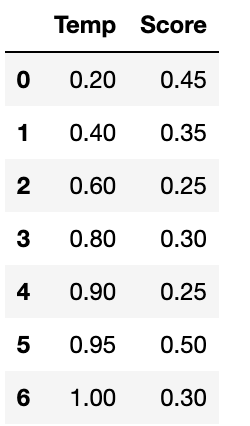

In [16]:
from IPython.display import Image
Image("img/majority_2.png", width= 110)

In [17]:
pd.set_option('display.max_colwidth', None)


In [18]:
df_maj

,question_number,question,answer_1,answer_2,answer_3,answer_4,answer_5,validation,CoT_0.2,Val_0.2,...,CoT_0.6,Val_0.6,CoT_0.8,Val_0.8,CoT_0.9,Val_0.9,CoT_0.95,Val_0.95,CoT_1,Val_1
0,1,What is left in the box?,"The box has a pencil, another 10 pencils and a strawberry.",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and another 10 pencils.",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and another pencil.",The box has 11 pencils and a strawberry.,"Answer: The box has a pencil, another 10 pencils and a strawberry. Reasoning step-by-step: 1. Count the number of times each answer appears in the list - Answer 1 = 1 time; Answer 2 = 1 time; Answer 3 = 2 times; Answer 4=1 time ;Answer 5=2 times 2. Choose the most frequent answer from this count – which is ‘The box has a pencil, another 10 pencils and a strawberry’ with an occurrence of two (2) out of five (5).",No,...,"Answer: The box has a pencil, another 10 pencils and a strawberry. Reasoning step-by-step: 1) Count how many times each answer appears - Answer 1 (The box has a pencil, another 10 pencils and a strawberry.): 3; Answer 2 (The box has 21 pencils and a strawberry.): 1; Answer 3 (The box hasa pencii, asrtrawberryand anotehr10pencilsl): 0; Answser 4(heboxhas21pneilsnadastawberrry);0Answe5Thboasw101epcislsatrwberyndanoherplncile):2 2) Choose the most frequent answer - In this case it is ""Answer 1"" with three occurrences. Therefore, the correct answer to “What is left in the Box?” is “the Box Has A Pencil Another 10 Pencil And A Strawberry"".",No,"Answer: The box has a pencil, another 10 pencils and a strawberry. This answer appears 3 times out of the 5 answers given, making it the most frequent one.",No,"Answer: The box has 21 pencils and a strawberry. This answer appears twice, which is the most frequent of all options given. Therefore this must be the correct answer to ""What is left in the box?"".",No,"The most frequent answer is: ""The box has a pencil, another 10 pencils and a strawberry."" This answer appears twice out of the five answers. All other words appear only once each. Therefore, this must be the correct answer to “What is left in the box?”",No,"Answer option: The box has a pencil, another 10 pencils and a strawberry. Reasoning: This answer appears 3 times in the set of answers above which is more than any other response meaning it must be the most frequent. It also provides an accurate description of what could be left in the box - 1 pencil, 10 other pencils and one strawberry. Therefore this step-by-step reasoning leads to conclusion that ""The box has a pencil, another 10 pensils and a strawbery"" is indeed correct answer to given question ""What is left in the box?"".",No
1,2,What is left in the box?,"The box has a pencil, another 10 pencils and a strawberry.",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and another 10 pencils.",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and another 11 pencils.",The box has 21 pencils and a strawberry.,"Answer: The box has a pencil, another 10 pencils and a strawberry. Reasoning: This answer appears 3 times out of the 5 answers given, making it the most frequent response to this question.",No,...,"Answer: The box has 21 pencils and a strawberry. Reasoning step-by-step: 1. Count the number of occurrences for each answer option – “The box has a pencil, another 10 pencils and a strawberry” (1), “The box has 21 pencils and a strawberry” (2), “The box has a pencil,a strawberry,and another 10pencils"" (1),""theboxhas21pencilsandastrawberry""(2)and ""theboxtenpencilsaustrawberryandaother11pensils""( 1). 2. Choose the most frequent answer which is ""The Box Has 21 Pencil And A Strawberry.""",Yes,"Answer: The box has a pencil, another 10 pencils and a strawberry. Reasoning step-by-step: 1. Count how many times each answer appears - ""The box has a pencil, another 10 pencils and a strawberry."" (3)

Sometimes it's too verbose and the equiv function gets confused.  Maybe re-writing the prompt so that it is more concise in it's initial answer.

In [19]:
prompt_beginning = """In the text below we have 5 answers to the same question. You will need to choose the popular option in an extremely short answer below."""            
nl_str = """\n\n"""
answers_str = """ANSWERS: \n"""
final_str_1 = """What is the answer to \""""
final_str_2 = """\". Count how many times each answer appears, reason step-by-step and respond in as few words as possible."""
# Notice we added the step by step reason in the last string



In [ ]:
score_list = []
for temp in temp_list:
    gpt_cot_list = []
    gpt_val_list = []
    print(temp)
    for row in df_maj.iterrows():
        question = row[1]['question']
        answers_concat =  "\n -" + row[1]['answer_1'] + "\n -" + row[1]['answer_2'] + "\n -" + row[1]['answer_3'] + "\n -" + row[1]['answer_4'] + "\n -" + row[1]['answer_5']
        prompt = prompt_beginning + nl_str + answers_str + answers_concat + nl_str + final_str_1 + question + final_str_2
        print(prompt)
        final_answer = gpt3_completion(prompt, temp = temp)
        #print(final_answer)
        #final_answer.replace('.','').replace(' ','')
        print(row[0])
        gpt_cot_list.append(final_answer)
        equiv_string = equiv(question, final_answer, row[1]['validation'])
        if equiv_string not in ['Yes','No']:
            prompt_init = """Condense the following sentence into a simple "Yes" or "No" answer"""
            prompt = prompt_init + nl_str + final_answer + nl_str + """ "Yes" or "No" output: """
            final_a = gpt3_completion(prompt, temp = 0.3)
            final_a.replace('.','').replace(' ','')
            equiv_string = final_a
        gpt_val_list.append(equiv_string)
    col_string_cot = 'CoT_'+ str(temp)
    col_string_val = 'Val_'+ str(temp)
    df_maj[col_string_cot] = gpt_cot_list
    df_maj[col_string_val] = gpt_val_list
    # validate against real answers using the equiv function above 
    score = sum(df_maj[col_string_val]=='Yes')/20
    score_list.append(score) 

In [21]:
df_results = pd.DataFrame(list(zip(temp_list, score_list)), columns =['Temp', 'Score'])
df_results

,Temp,Score
0,0.20,0.25
1,0.40,0.25
2,0.60,0.25
3,0.80,0.25
4,0.90,0.25
5,0.95,0.25
6,1.00,0.30


Again, worse than prior results as seen below:

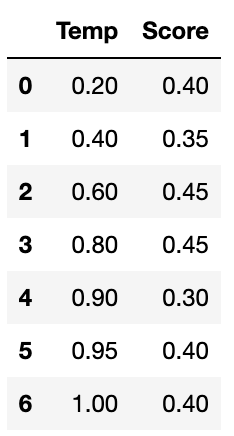

In [23]:
from IPython.display import Image
Image("img/majority_3.png", width= 110)

In [24]:
df_maj

,question_number,question,answer_1,answer_2,answer_3,answer_4,answer_5,validation,CoT_0.2,Val_0.2,...,CoT_0.6,Val_0.6,CoT_0.8,Val_0.8,CoT_0.9,Val_0.9,CoT_0.95,Val_0.95,CoT_1,Val_1
0,1,What is left in the box?,"The box has a pencil, another 10 pencils and a strawberry.",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and another 10 pencils.",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and another pencil.",The box has 11 pencils and a strawberry.,21 pencils and a strawberry.,No,...,The box has 21 pencils and a strawberry.,No,21 pencils and a strawberry.,No,21 pencils and a strawberry.,No,The box has 21 pencils and a strawberry.,No,21 pencils and a strawberry.,No
1,2,What is left in the box?,"The box has a pencil, another 10 pencils and a strawberry.",The box has 21 pencils and a strawberry.,"The box has a pencil, a strawberry, and another 10 pencils.",The box has 21 pencils and a strawberry.,"The box has 10 pencils, a strawberry, and another 11 pencils.",The box has 21 pencils and a strawberry.,21 pencils and a strawberry.,No,...,21 pencils and a strawberry.,No,21 pencils and a strawberry.,No,21 pencils and a strawberry.,No,21 pencils and 1 strawberry.,Yes,21 pencils and a strawberry.,No
2,3,Should congress pass the law?,The law should go through,The law should be banned,The law should get the greenlight,The law should not be part of the constitution,The law should be implemented,The law should go through,The law should be implemented.,Yes,...,The law should be implemented.,No,The law should be implemented.,No,The law should be implemented.,No,The law should be implemented.,No,The law should go through.,Yes
3,4,Should congress pass the law?,The law should go through,The law should be banned,The law should get the greenlight,The law should not be part of the constitution,The law should not be implemented,The law should not be implemented,The law should go through.,No,...,The law should go through.,No,The law should go through.,No,The law should go through.,No,The law should go through.,No,The law should go through.,No
4,5,Did the experiment work correctly?,Yes,No,I don't know,Most likely,Probably,Yes,Yes: 4,No,...,Probably.,No,Yes: 4,No,Probably,No,Most likely.,No,Most likely.,No
5,6,Did the experiment work correctly?,Yes,No,I don't know,I'm not sure,Probably not,No,Yes,No,...,Yes,No,Yes,No,Yes,No,Yes,No,"Yes: 3, No: 1, I don't know: 0, I'm not sure: 1, Probably not :1 Answer = Yes",No
6,7,How should I wash my hands?,Use handsoap,Use soap,Use alcohol,Use aloe vera soap,Use shampoo,Soap,Use soap.,No,...,Use soap.,No,Use soap.,No,Use soap.,No,Use soap.,No,Use soap.,No
7,8,How should I wash my hands?,Use hair shampoo,Use soap,Use shampoo,Use aloe vera soap,Use shampoo,Shampoo,Use shampoo (3 times),No,...,Use shampoo (3 times),No,Answer: Use shampoo (3 times),No,Use shampoo.,No,Use shampoo (3 times),No,Use shampoo (3 times),No
8,9,What should we eat today?,Pizza,Sushi,Pizza or Sushi,Sushi,Hamburger,Sushi,Pizza.,No,...,Pizza.,No,Pizza.,No,Pizza.,No,Pizza.,No,Pizza.,No
9,10,What should we eat today?,Pizza,Sushi,Pizza,Sushi or Pizza,Hamburger,Pizza,Pizza (3x),Yes,...,Pizza.,Yes,Pizza.,Yes,Pizza (2),Yes,Pizza.,Yes,Pizza.,Yes


The results seem disappointing. However, it might be the case that the new model is more precise, and expects two answers to be totally equivalent i.e. "Yes" and "Most likely" are not the same for the model.  Which means this experiment doesn't make much sense.


## 4. Conclusion

I will still park this experiment as a failure. I was quite generous with GPT4 and chatGPT and still we only get a 76% accuracy. I tried some prompt engineering, some back and forth chatting, reasoning, etc, and some of these questions it will simply not "get it". Even when explicitly asking it to try and group the answers and going step-by-step, still won't. Never tried with fine tuning though, that seems like it should give visible improvements.